In [59]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../../script/')
import math
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import pydotplus
from sklearn import tree
from IPython.display import Image

import cleaning_class as cl
import cleaning_test as cl_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

### Label Encoder and one hot encoder

In [62]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_NY',
       'VNST_OH', 'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN',
       'VNST_TX', 'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV',
       'WheelTypeID_1.0', 'WheelTypeID_2.0',

### Train/Validation partitioning

In [63]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
x = df[attributes].values
y = df['IsBadBuy']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
sm = SMOTE(sampling_strategy=1.0, random_state=42)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

### GridSearch

In [64]:
def report(results, n_top=3):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

In [67]:
param_list = {
    'criterion':['gini', 'entropy'], 
    'max_depth': range(2, 15, 1), 
    'min_samples_split':range(6, 12, 1),
    'min_samples_leaf':range(2, 20, 1),
    'min_impurity_decrease': [0.75e-6, 0.5e-6, 1e-6]
    }
new_params = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}

#kf = KFold(n_splits=5, random_state=42, shuffle=True)
skf = StratifiedKFold(n_splits=3)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
imba_pipeline = make_pipeline(SMOTE(sampling_strategy= 1.0, random_state=42), clf)

#grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, cv=skf, n_iter=400, return_train_score=True, scoring='f1', n_jobs = 4, verbose = 1)
grid_imba = RandomizedSearchCV(imba_pipeline, param_distributions=new_params, cv=skf, n_iter=4000, scoring='roc_auc', n_jobs = 4, verbose = 1)

grid_imba.fit(x, y)
cnfs = report(grid_imba.cv_results_, n_top=3)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/alessandro/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 19.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 24.2min
[Parallel(n_jobs=

Model with rank: 1
Mean validation score: 0.658 (std: 0.007)
Parameters: {'decisiontreeclassifier__min_samples_split': 12, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_impurity_decrease': 5e-07, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.658 (std: 0.007)
Parameters: {'decisiontreeclassifier__min_samples_split': 14, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_impurity_decrease': 1e-06, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.658 (std: 0.007)
Parameters: {'decisiontreeclassifier__min_samples_split': 6, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_impurity_decrease': 5e-07, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'gini'}



### Perform Clustering

In [68]:
models = []
y_pred_vals = []
y_pred_trains = []
hyper_ps = grid_imba.cv_results_
for cnf in cnfs.values():
    criterion = cnf['decisiontreeclassifier__criterion']
    max_depth = cnf['decisiontreeclassifier__max_depth']
    min_samples_split = cnf['decisiontreeclassifier__min_samples_split']
    min_samples_leaf = cnf['decisiontreeclassifier__min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_train, y_train)
    models.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_train)
    y_pred_vals.append(y_pred)
    y_pred_trains.append(y_pred_tr)   

In [36]:
### Analyze the classification results

In [69]:
for i in range(0,len(cnfs)):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_trains[i]))
    print('Train F1-score %s' % f1_score(y_train, y_pred_trains[i], average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals[i], average=None))
    print(classification_report(y_val, y_pred_vals[i]))
    confusion_matrix(y_val, y_pred_vals[i])

model 0
Train Accuracy 0.8891691587569887
Train F1-score [0.940533   0.18664122]

Test Accuracy 0.8830239048659143
Test F1-score [0.93726409 0.13620072]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     14480
           1       0.66      0.08      0.14      2002

    accuracy                           0.88     16482
   macro avg       0.77      0.54      0.54     16482
weighted avg       0.86      0.88      0.84     16482

model 1
Train Accuracy 0.8891691587569887
Train F1-score [0.940533   0.18664122]

Test Accuracy 0.8825385268778061
Test F1-score [0.93699147 0.13494191]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     14480
           1       0.64      0.08      0.13      2002

    accuracy                           0.88     16482
   macro avg       0.76      0.53      0.54     16482
weighted avg       0.86      0.88      0.84     16482

model 2
Train Accuracy 0.889169158756988

### Analyze the classification performance

In [70]:
roc_auc_models = []
for i in range(0,len(cnfs)):
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.5352686677962921
model 1 - roc_auc: 0.5347772048393595
model 2 - roc_auc: 0.5347772048393595


### Choose the best model

Visualize the decision tree

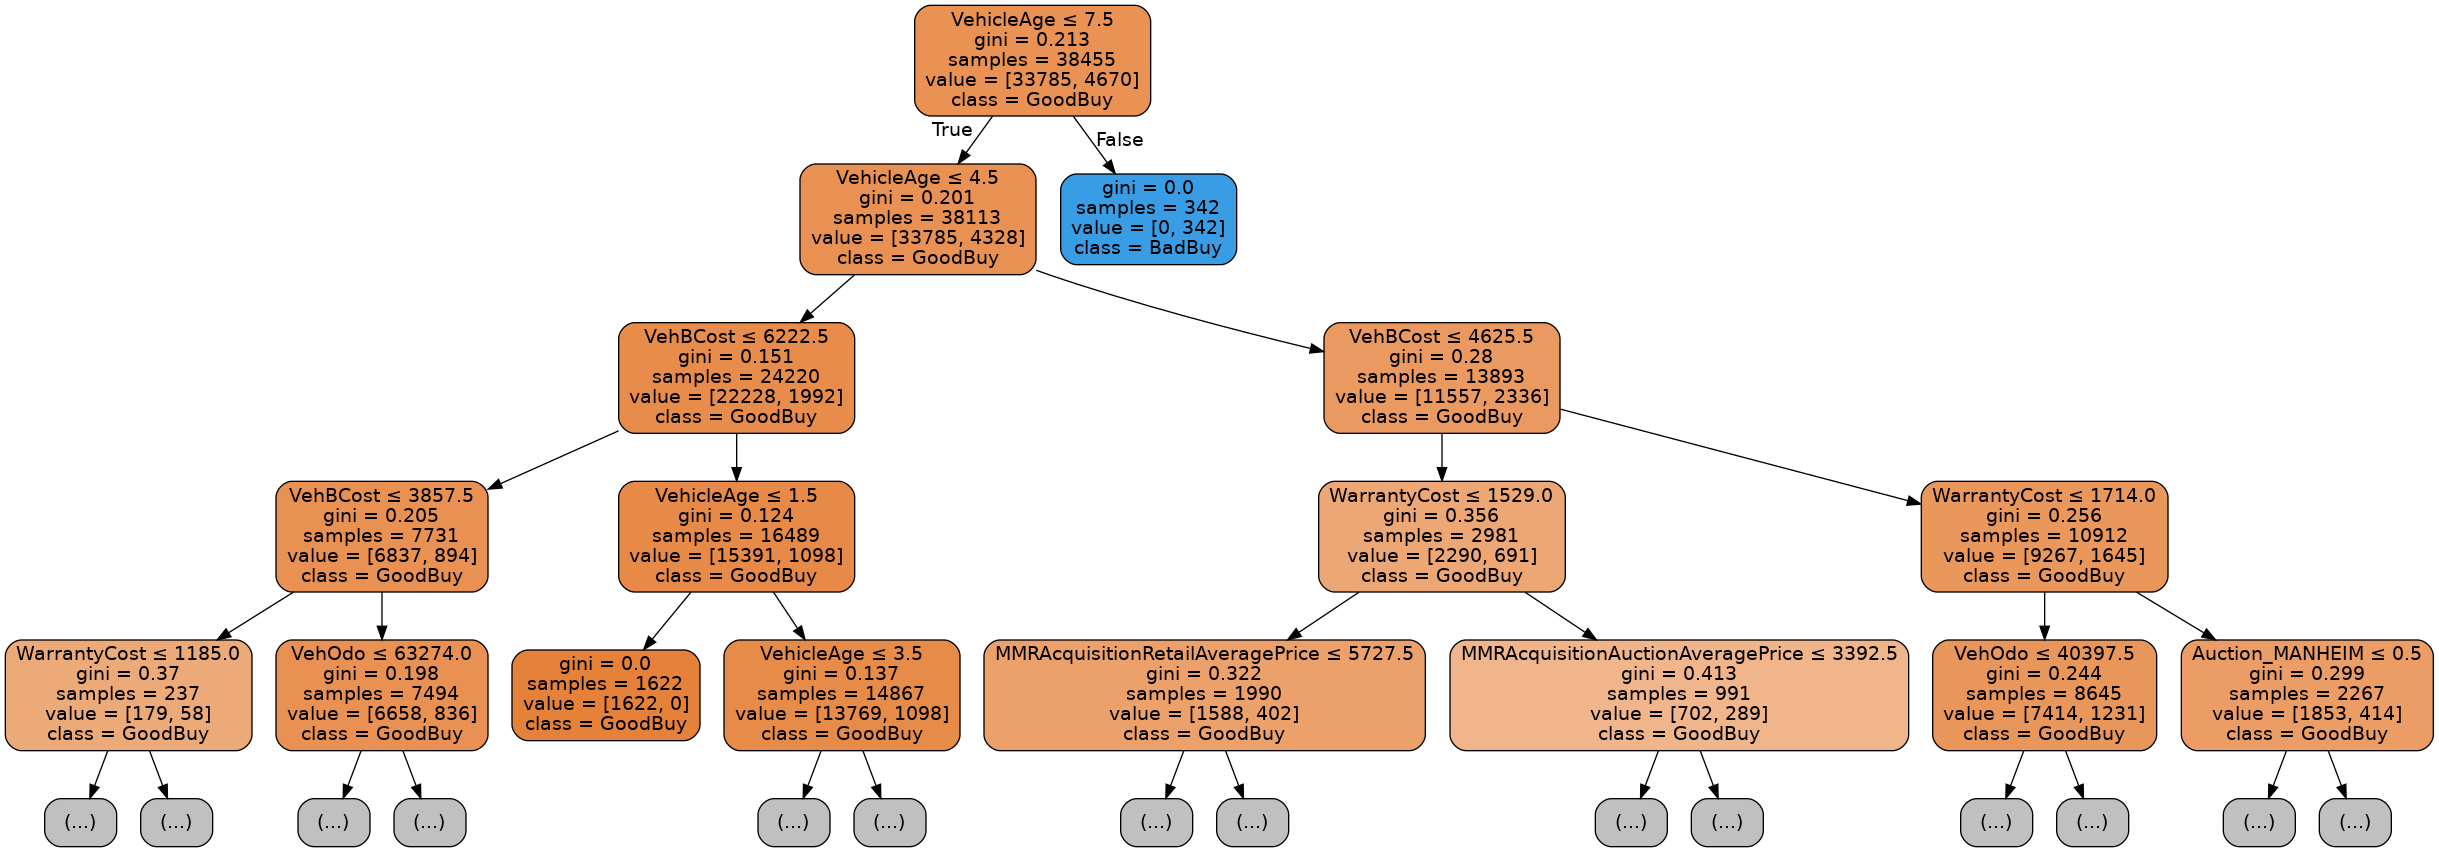

In [71]:
dot_data = tree.export_graphviz(models[0], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

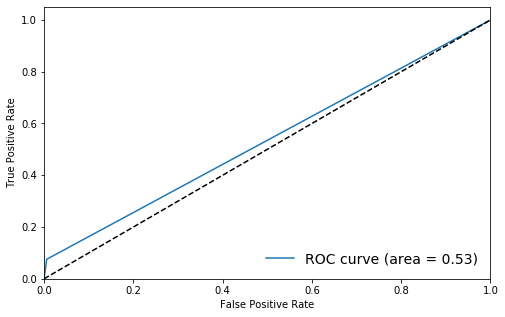

In [72]:
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models[1]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

Features Importance

In [54]:
for col, imp in zip(attributes, models[2].feature_importances_):
    print(col, imp)

VehicleAge 0.6009229989868534
VehOdo 0.046629324224803974
MMRAcquisitionAuctionAveragePrice 0.05671174746546963
MMRAcquisitionRetailAveragePrice 0.060592187919847725
MMRCurrentAuctionAveragePrice 0.03243399491447979
MMRCurrentRetailAveragePrice 0.03715911235068149
VehBCost 0.04930359457791383
WarrantyCost 0.035717504180912456
Auction_ADESA 0.009931476364567036
Auction_MANHEIM 0.010549159642052603
Auction_OTHER 0.0
Size_COMPACT 0.006398115051295323
Size_CROSSOVER 0.0010064295340800943
Size_LARGE 0.001343264141692001
Size_LARGE SUV 0.00028982261526316004
Size_LARGE TRUCK 0.0
Size_MEDIUM 0.0014550385656955235
Size_MEDIUM SUV 0.0010217072120697627
Size_SMALL SUV 0.0
Size_SMALL TRUCK 0.0
Size_SPECIALTY 0.0
Size_SPORTS 0.0
Size_VAN 0.001997093911141728
TopThreeAmericanName_CHRYSLER 0.0012714101855209744
TopThreeAmericanName_FORD 0.007458281289702852
TopThreeAmericanName_GM 0.008047966345743934
TopThreeAmericanName_OTHER 0.0026742784121387988
VNST_AL 0.0
VNST_AR 0.0
VNST_AZ 0.0
VNST_CA 0.0010

In [111]:
# Model evaluation on test set

In [114]:
df_test = pd.read_csv('../../data/test.csv') 
cl_test.cleaning(df_test)
df_test.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Transmission', 'WheelTypeID',
       'VehOdo', 'Nationality', 'Size', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VNST', 'VehBCost', 'WarrantyCost'],
      dtype='object')

In [115]:
df_test = pd.get_dummies(df_test)
df_test = pd.get_dummies(df_test, columns=['WheelTypeID'])
df_test.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER',
       'Transmission_AUTO', 'Transmission_MANUAL', 'Nationality_AMERICAN',
       'Nationality_OTHER', 'Nationality_OTHER ASIAN',
       'Nationality_TOP LINE ASIAN', 'Size_COMPACT', 'Size_CROSSOVER',
       'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK', 'Size_MEDIUM',
       'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD

In [116]:
attributes = [col for col in df_test.columns if col != 'IsBadBuy']
x_test = df_test[attributes].values
y_test = df_test['IsBadBuy']

In [117]:
y_pred_test = models[0].predict(x_test)

Test Accuracy 0.860646752534941
Test F1-score [0.92429656 0.12478485]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     12828
           1       0.26      0.08      0.12      1768

    accuracy                           0.86     14596
   macro avg       0.57      0.52      0.52     14596
weighted avg       0.81      0.86      0.83     14596

Confusion matrix, without normalization
[[12417   411]
 [ 1623   145]]
Normalized confusion matrix
[[0.96796071 0.03203929]
 [0.91798643 0.08201357]]


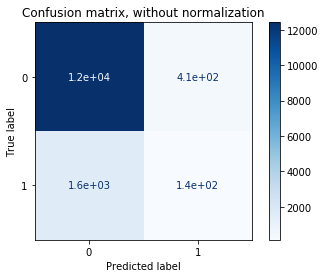

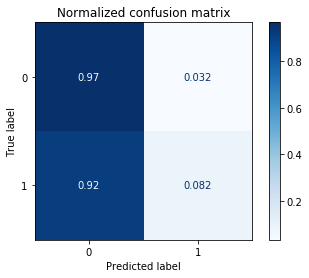

In [120]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('Test F1-score %s' % f1_score(y_test, y_pred_test, average=None))
print(classification_report(y_test, y_pred_test))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(models[0], x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()


In [121]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_pred_test, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.5249871428027209


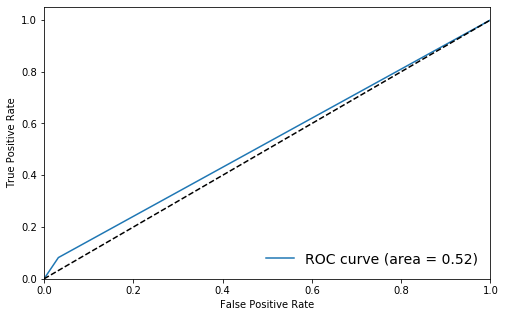

In [122]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# Stratified sampling

In [100]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
X = df[attributes].values
y = df['IsBadBuy']

In [ ]:
# Model evaluation on test set